In [1]:
import torch
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from tqdm import tqdm
from modules.losses import SupConLoss
from modules.backbones import ResNet50
from modules.datasets import MultiLabelDataset
from modules.siamese import ContrastiveNetwork
from modules.callbacks import LossTracker,ModelSaver
from modules.trainer import Trainer
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*") # we want to run Single-Core in the Notebook -> Ignore this warning
warnings.simplefilter(action='ignore', category=FutureWarning)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "./runs/dataset_sizes"

C:\Users\Lukas\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this Notebook we train on different sample-sizes per class.

In [2]:
dataset = MultiLabelDataset(
    "./tiny-imagenet-200/train",
    cache_in_ram=True,
    transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),
    max_classes=50
    )
len(dataset)

25000

In [3]:
#Build the DataLoaders
BATCH_SIZE = 128
def Build_Loaders(train_samples):
    train_indices = []
    val_indices = []
    for dataset_range in dataset.ranges:
        #Only take n_samples from each dataset
        train_indices += list(range(dataset_range.start,dataset_range.start+train_samples))
        val_indices += list(range(dataset_range.start+400,dataset_range.stop))
        
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,pin_memory=True)
    return train_loader,val_loader

In [4]:
#Train the Models
Epochs = 5
sample_sizes = [10,20,30,50,80,100,200,400]
for sample_size in sample_sizes: 
    siamese_model = ContrastiveNetwork(ResNet50(pretrained=True,freeze=False),SupConLoss())
    
    model_dir = os.path.join(SAVE_DIR,str(sample_size))
    if os.path.isdir(model_dir):
        continue
    os.makedirs(model_dir,exist_ok=True)
    
    lossTracker = LossTracker()
    modelSaver = ModelSaver(model_dir)
    train_loader,val_loader = Build_Loaders(sample_size)

    trainer = Trainer(max_epochs=Epochs,callbacks=[lossTracker,modelSaver])
    trainer.fit(model=siamese_model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    lossTracker.save(model_dir)
    torch.cuda.empty_cache()
    gc.collect()

In [5]:
from modules.knn import KNN

knns = {}

for sample_size in sample_sizes:
    train_loader,val_loader = Build_Loaders(sample_size)
    model:torch.nn.Module = ResNet50()
    size_name = str(sample_size)
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR,size_name,"checkpoints",f"epoch_{Epochs-1}.pth")))
    model = model.to(DEVICE)
    knns[size_name] = KNN(model,train_loader,os.path.join(SAVE_DIR,size_name))

In [6]:
train_loader,val_loader = Build_Loaders(1)

results = {}

for sample_size in sample_sizes: 
    model:torch.nn.Module = ResNet50()
    size_name = str(sample_size)
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR,size_name,"checkpoints",f"epoch_{Epochs-1}.pth")))
    model = model.to(DEVICE)

    embeddings = []
    labels = []
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader,size_name):
            img,label = batch
            embedding = model(img.to(DEVICE)).cpu().numpy()
            embeddings.append(embedding)  
            labels.append(label)
    
    results[size_name] = (np.vstack(embeddings),np.vstack(labels).reshape(-1))

400: 100%|██████████| 40/40 [00:00<00:00, 52.34it/s]


In [7]:
from sklearn.metrics import f1_score  

for key in results:
    embeddings,labels = results[key]
    predictions = knns[key].querry_labels(embeddings)
    print(f"{key} F1-Score: {f1_score(predictions,labels,average='macro'):.3f}")

10 F1-Score: 0.223
20 F1-Score: 0.280
30 F1-Score: 0.368
50 F1-Score: 0.443
80 F1-Score: 0.507
100 F1-Score: 0.520
200 F1-Score: 0.631
400 F1-Score: 0.703


Building T-SNE plots: 8it [00:42,  5.34s/it]


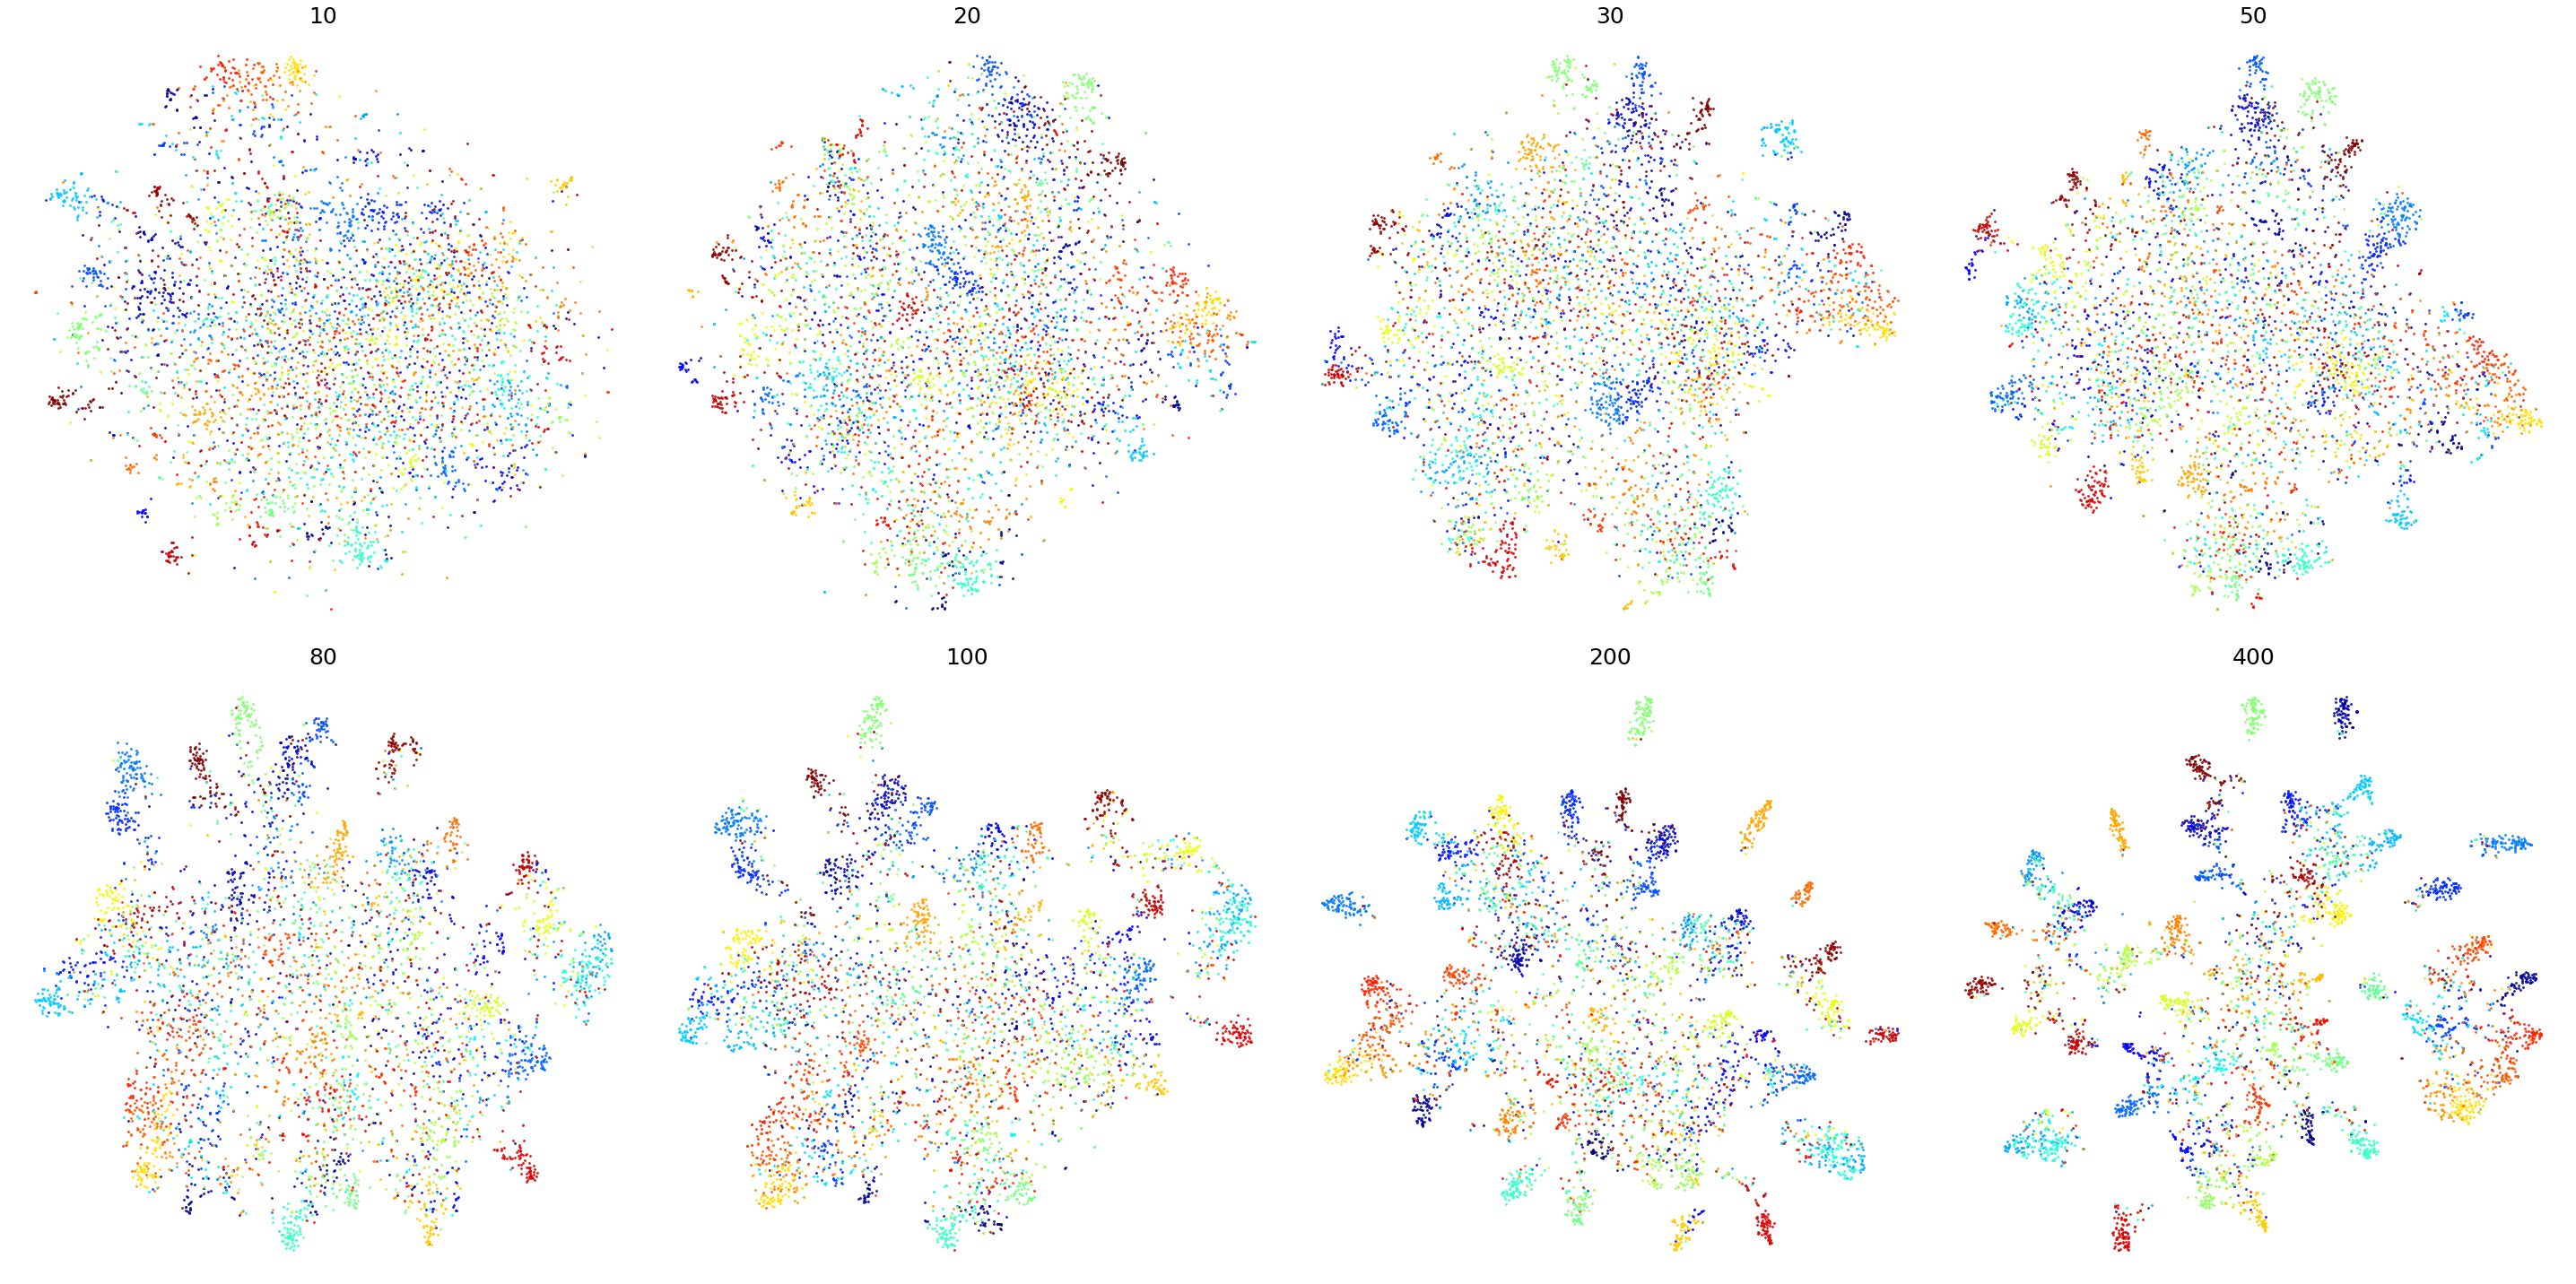

In [8]:
import matplotlib.pyplot as plt
from modules.plotting import plot_results

plot_results(results,"dataset_size",max_columns=4)
plt.show()